In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv("SHEL_data.csv")

In [3]:
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,36.250000,36.360001,35.494999,36.029999,31.140999,6794599
1,2021-01-05,37.189999,39.014999,37.115002,38.509998,33.284489,8518589
2,2021-01-06,39.910000,40.680000,39.564999,40.290001,34.822952,9180332
3,2021-01-07,40.000000,40.625000,39.744999,40.340000,34.866161,4829303
4,2021-01-08,40.360001,40.419998,39.770000,40.240002,34.779736,5546750
...,...,...,...,...,...,...,...
972,2024-11-13,65.010002,65.800003,64.459999,65.480003,64.795242,5945070
973,2024-11-14,65.879997,66.120003,65.650002,65.790001,65.101997,5438087
974,2024-11-15,65.489998,65.769997,65.269997,65.470001,65.470001,4349310
975,2024-11-18,66.110001,66.570000,65.915001,66.320000,66.320000,3329354


In [5]:
import math, os, torch, numpy as np, pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [6]:
SEQ_LEN     = 60                
BATCH_SIZE  = 64
EPOCHS      = 30
LR          = 1e-3
HIDDEN_SIZE = 64
N_LAYERS    = 1
N_FUTURE    = 10     

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
torch.manual_seed(42)
np.random.seed(42)

In [10]:
dataset["Date"] = pd.to_datetime(dataset["Date"])

In [11]:
df = dataset

In [12]:
df = df.sort_values("Date").reset_index(drop = True)

In [13]:
feature_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

In [14]:
full_cols = ["Date"] + feature_cols

In [15]:
df = df[["Date","Open","High","Low","Close","Adj Close","Volume"]]

In [16]:
values = df[feature_cols].values.astype(np.float32)

In [17]:
scaler = StandardScaler()
values_scaled = scaler.fit_transform(values).astype(np.float32)

In [18]:
class SeqDataset(Dataset):
    def __init__(self, array, seq_len):
        self.X, self.y = [], []
        T, D = array.shape
        for i in range(T - seq_len):
            
            self.X.append(array[i:i+seq_len])
            self.y.append(array[i+seq_len])
        self.X = np.stack(self.X)
        self.y = np.stack(self.y)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])

In [19]:
N = values_scaled.shape[0]

In [20]:
values_scaled

array([[-1.8673202 , -1.9024163 , -1.8971177 , -1.8909522 , -1.795083  ,
         1.1127659 ],
       [-1.7782729 , -1.650474  , -1.7435184 , -1.6557527 , -1.6121547 ,
         2.1106062 ],
       [-1.5206033 , -1.492476  , -1.5112238 , -1.4869397 , -1.4808602 ,
         2.493621  ],
       ...,
       [ 0.9026257 ,  0.8884052 ,  0.925977  ,  0.9010957 ,  1.1345996 ,
        -0.3025601 ],
       [ 0.96135944,  0.9643204 ,  0.9871326 ,  0.98170835,  1.2071395 ,
        -0.8929076 ],
       [ 0.9395709 ,  0.92731196,  0.9534732 ,  0.9333405 ,  1.1636152 ,
        -1.4159161 ]], shape=(977, 6), dtype=float32)

In [22]:
split = int(N * 0.9)

In [23]:
train_ds = SeqDataset(values_scaled[:split], SEQ_LEN)

In [24]:
val_ds = SeqDataset(values_scaled[split-SEQ_LEN:], SEQ_LEN)

In [25]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [26]:
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [27]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            nonlinearity="tanh",
            batch_first=True
        )
        self.head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        h, _ = self.rnn(x)
        last = h[:, -1, :]
        out = self.head(last)
        return out

In [28]:
D = values_scaled.shape[1]

In [29]:
model = SimpleRNN(input_size=D, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS, output_size=D).to(device)

In [30]:
opt = torch.optim.Adam(model.parameters(), lr=LR)

In [31]:
loss_fn = nn.MSELoss()


In [33]:
def evaluate():
    model.eval()
    total, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total += loss_fn(pred, yb).item() * xb.size(0)
            n += xb.size(0)
    return total / max(1, n)

In [34]:
best_val = math.inf

In [36]:
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
    val_loss = evaluate()
    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:3d} | train_loss {loss.item():.6f} | val_loss {val_loss:.6f}")

epoch   1 | train_loss 0.219095 | val_loss 0.369446
epoch   5 | train_loss 0.102441 | val_loss 0.194450
epoch  10 | train_loss 0.128977 | val_loss 0.183942
epoch  15 | train_loss 0.104764 | val_loss 0.175544
epoch  20 | train_loss 0.173838 | val_loss 0.175810
epoch  25 | train_loss 0.096025 | val_loss 0.173479
epoch  30 | train_loss 0.145177 | val_loss 0.171929


In [37]:
model.load_state_dict(best_state)

<All keys matched successfully>

In [38]:
model.to(device)

SimpleRNN(
  (rnn): RNN(6, 64, batch_first=True)
  (head): Linear(in_features=64, out_features=6, bias=True)
)

In [39]:
model.eval()

SimpleRNN(
  (rnn): RNN(6, 64, batch_first=True)
  (head): Linear(in_features=64, out_features=6, bias=True)
)

In [41]:
with torch.no_grad():
    # last window from the full series
    last_window = values_scaled[-SEQ_LEN:].copy()  # [T, D]
    window_t = torch.from_numpy(last_window).unsqueeze(0).to(device)  # [1, T, D]

    preds_scaled = []
    cur_window = window_t.clone()

    for _ in range(N_FUTURE):
        next_step = model(cur_window)          # [1, D] scaled
        preds_scaled.append(next_step.squeeze(0).cpu().numpy())
        # append and drop oldest for next iteration
        next_step_expanded = next_step.unsqueeze(1)          # [1, 1, D]
        cur_window = torch.cat([cur_window[:, 1:, :], next_step_expanded], dim=1)

    preds_scaled = np.stack(preds_scaled, axis=0)  # [N_FUTURE, D]
    preds = scaler.inverse_transform(preds_scaled) # back to original units

In [42]:
last_date = df["Date"].iloc[-1]

In [43]:
future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=N_FUTURE)

In [44]:
pred_df = pd.DataFrame(preds, columns=feature_cols)

In [45]:
pred_df.insert(0, "Date", future_dates)

In [46]:
print(pred_df.head(N_FUTURE))

        Date       Open       High        Low      Close  Adj Close  \
0 2024-11-20  66.650665  67.289856  66.446693  67.273949  64.193352   
1 2024-11-21  66.973671  67.562698  66.813721  67.199188  64.533913   
2 2024-11-22  67.266487  67.863464  67.181473  67.494034  64.854919   
3 2024-11-25  67.619186  68.115280  67.396492  67.822144  65.072678   
4 2024-11-26  67.987297  68.390335  67.566689  68.021576  65.284294   
5 2024-11-27  68.261841  68.628326  67.781693  68.230537  65.594566   
6 2024-11-28  68.488235  68.888359  68.053635  68.490410  65.896576   
7 2024-11-29  68.747498  69.137810  68.345909  68.777916  66.175980   
8 2024-12-02  69.023186  69.401352  68.618385  69.067734  66.445045   
9 2024-12-03  69.291107  69.663055  68.875816  69.337357  66.723648   

       Volume  
0  3647420.50  
1  4072515.75  
2  4183657.00  
3  4211240.50  
4  4302908.50  
5  4394773.50  
6  4450270.00  
7  4476374.50  
8  4492916.50  
9  4506395.50  


In [47]:
def one_step_tail_predictions(n_tail=60):
    """Return last n_tail actual vs. one-step predictions for inspection."""
    xs, ys = [], []
    arr = values_scaled[-(n_tail+SEQ_LEN):]  # just a tail
    for i in range(arr.shape[0] - SEQ_LEN):
        xs.append(arr[i:i+SEQ_LEN])
        ys.append(arr[i+SEQ_LEN])
    xs = torch.from_numpy(np.stack(xs)).to(device)
    ys = np.stack(ys)
    with torch.no_grad():
        pred_scaled = model(xs).cpu().numpy()
    pred = scaler.inverse_transform(pred_scaled)
    truth = scaler.inverse_transform(ys)
    dates_aligned = df["Date"].iloc[-len(truth):].reset_index(drop=True)
    out = pd.DataFrame(np.concatenate([truth, pred], axis=1),
                       columns=[f"true_{c}" for c in feature_cols] + [f"pred_{c}" for c in feature_cols])
    out.insert(0, "Date", dates_aligned)
    return out

In [50]:
tail_compare = one_step_tail_predictions(120)
tail_pred_df = tail_compare.tail(60)

In [51]:
tail_pred_df.columns

Index(['Date', 'true_Open', 'true_High', 'true_Low', 'true_Close',
       'true_Adj Close', 'true_Volume', 'pred_Open', 'pred_High', 'pred_Low',
       'pred_Close', 'pred_Adj Close', 'pred_Volume'],
      dtype='object')

In [52]:
true_adj_close = tail_pred_df['true_Adj Close'].values
pred_adj_close = tail_pred_df['pred_Adj Close'].values

In [54]:
import matplotlib.pyplot as plt

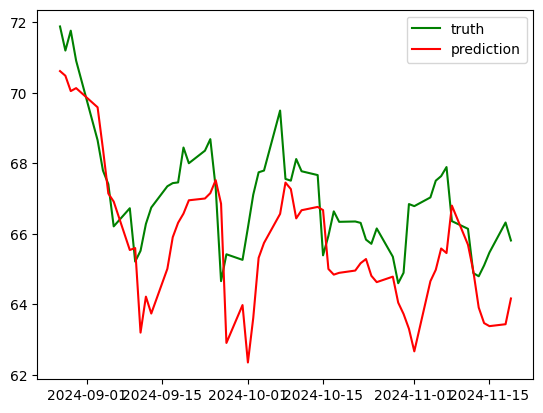

In [59]:
plt.plot(tail_pred_df['Date'].values, true_adj_close, c = 'green', label = 'truth')
plt.plot(tail_pred_df['Date'].values, pred_adj_close, c = 'red', label = 'prediction')
plt.legend()
plt.show()